In [2]:
# Necessary imports in general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Step 1 : Extraction of RSS Flow

## Getting the list of files' name

In [3]:
import os
# adapt path name 
path = "data_pour_TD_final/"
avis_list = os.listdir(path+"avis")
alert_list = os.listdir(path+"alertes")
mitre_list = os.listdir(path+"mitre")
first_list = os.listdir(path+"first")

In [4]:
print(len(avis_list))

2673


In [5]:
# will list all dictionaries in this list because it's cheaper than growing the data frame
cve_list = []

## Get the information for avis

In [6]:
for avis_id in avis_list:
    with open(path+"avis/"+avis_id, 'r') as f:
        data = json.load(f)
        for cve in data["cves"]:
            # basic info
            cve_id = cve['name']
            dico = {
                'id': avis_id,
                'title': '',
                'type': 'Avis',
                'publication_date': None,
                'cve_id': cve_id,
                'original_link': None,
                'epss' : np.nan,
                'description': None,
                'cwe': 'Non disponible',
                'cwe_desc' : 'Non disponible',
                'vendor': [],
                'product': [],
                'affected_versions': [],
                'cvss': np.nan,
                'severity': None
            }
            # other info from avis
            if data['vendor_advisories'] and 'title' in data['vendor_advisories'][0]:
                dico['title'] = data['vendor_advisories'][0]['title']
            if data['vendor_advisories'] and 'published_at' in data['vendor_advisories'][0]:
                dico['publication_date'] = data['vendor_advisories'][0]['published_at']
            if data['vendor_advisories'] and 'url' in data['vendor_advisories'][0]:
                dico['original_link'] = data['vendor_advisories'][0]['url']
            # info from first
            if cve_id in first_list:
                with open(path+"first/"+cve_id, 'r') as f1:
                    data_first = json.load(f1)
                    if data_first['data'] and 'epss' in data_first['data'][0]:
                        dico['epss'] = data_first['data'][0]['epss']
                    
            # info from mitre
            if cve_id in mitre_list :
                with open(path+"mitre/"+cve_id, 'r') as f2:
                    data_mitre = json.load(f2)
                    if 'containers' in data_mitre.keys() and 'descriptions' in data_mitre['containers']['cna'].keys():
                        dico['description'] = data_mitre['containers']['cna']['descriptions'][0]['value']
    
                        # getting cwe
                        problemtype = data_mitre["containers"]["cna"].get("problemTypes", {})
                        if problemtype and "descriptions" in problemtype[0].keys(): 
                            dico['cwe'] = problemtype[0]["descriptions"][0].get("cweId", "Non disponible") 
                            dico['cwe_desc']=problemtype[0]["descriptions"][0].get("description", "Non disponible")
    
                        # getting affected products
                        affected = data_mitre['containers']['cna']['affected']
                        for product in affected:
                            if 'vendor' in product.keys() and product['vendor'] not in dico['vendor']:
                                dico['vendor'].append(product['vendor'])
                            if 'product' in product.keys() and product['product'] not in dico['product']:
                                dico['product'].append(product['product'])
                            if 'versions' in product:
                                dico['affected_versions'] = [v["version"] for v in product["versions"] if v["status"] == "affected"]
    
                        # getting cvss score and severity
                        keys = ['cvssV3_0', 'cvssV3_1', 'cvssV2', 'cvssV4_0']
                        if 'metrics' in data_mitre['containers']['cna'].keys():
                            cvss_info = data_mitre['containers']['cna']['metrics'][0]
                            for key in keys :
                                if key in cvss_info.keys():
                                    dico['cvss'] = cvss_info[key]['baseScore']
                                    dico['severity'] = cvss_info[key]['baseSeverity']
            cve_list.append(dico)
                            

            

## Get the information for alertes

In [7]:
for alert_id in alert_list:
    with open(path+"alertes/"+alert_id, 'r') as f:
        data = json.load(f)
        for cve in data["cves"]:
            # basic info
            cve_id = cve['name']
            dico = {
                'id': alert_id,
                'title': '',
                'type': 'Alerte',
                'publication_date': None,
                'cve_id': cve_id,
                'original_link': None,
                'epss' : np.nan,
                'description': None,
                'cwe': 'Non disponible',
                'cwe_desc' : 'Non disponible',
                'vendor': [],
                'product': [],
                'affected_versions': [],
                'cvss': np.nan,
                'severity': None
            }
            # other info from avis
            if data['vendor_advisories'] and 'title' in data['vendor_advisories'][0]:
                dico['title'] = data['vendor_advisories'][0]['title']
            if data['vendor_advisories'] and 'published_at' in data['vendor_advisories'][0]:
                dico['publication_date'] = data['vendor_advisories'][0]['published_at']
            if data['vendor_advisories'] and 'url' in data['vendor_advisories'][0]:
                dico['original_link'] = data['vendor_advisories'][0]['url']
            # info from first
            if cve_id in first_list:
                with open(path+"first/"+cve_id, 'r') as f1:
                    data_first = json.load(f1)
                    if data_first['data'] and 'epss' in data_first['data'][0]:
                        dico['epss'] = data_first['data'][0]['epss']
                    
            # info from mitre
            if cve_id in mitre_list :
                with open(path+"mitre/"+cve_id, 'r') as f2:
                    data_mitre = json.load(f2)
                    if 'containers' in data_mitre.keys() and 'descriptions' in data_mitre['containers']['cna'].keys():
                        dico['description'] = data_mitre['containers']['cna']['descriptions'][0]['value']
    
                        # getting cwe
                        problemtype = data_mitre["containers"]["cna"].get("problemTypes", {})
                        if problemtype and "descriptions" in problemtype[0].keys(): 
                            dico['cwe'] = problemtype[0]["descriptions"][0].get("cweId", "Non disponible") 
                            dico['cwe_desc']=problemtype[0]["descriptions"][0].get("description", "Non disponible")
    
                        # getting affected products
                        affected = data_mitre['containers']['cna']['affected']
                        for product in affected:
                            if 'vendor' in product.keys() and product['vendor'] not in dico['vendor']:
                                dico['vendor'].append(product['vendor'])
                            if 'product' in product.keys() and product['product'] not in dico['product']:
                                dico['product'].append(product['product'])
                            if 'versions' in product:
                                dico['affected_versions'] = [v["version"] for v in product["versions"] if v["status"] == "affected"]
    
                        # getting cvss score and severity
                        keys = ['cvssV3_0', 'cvssV3_1', 'cvssV2', 'cvssV4_0']
                        if 'metrics' in data_mitre['containers']['cna'].keys():
                            cvss_info = data_mitre['containers']['cna']['metrics'][0]
                            for key in keys :
                                if key in cvss_info.keys():
                                    dico['cvss'] = cvss_info[key]['baseScore']
                                    dico['severity'] = cvss_info[key]['baseSeverity']
            cve_list.append(dico)

In [14]:
df = pd.DataFrame(cve_list)
df.head

<bound method NDFrame.head of                          id  \
0      CERTFR-2023-AVI-0963   
1      CERTFR-2025-AVI-0119   
2      CERTFR-2025-AVI-0119   
3      CERTFR-2025-AVI-0119   
4      CERTFR-2025-AVI-0119   
...                     ...   
60794   CERTFR-2021-ALE-009   
60795   CERTFR-2021-ALE-007   
60796   CERTFR-2021-ALE-007   
60797   CERTFR-2021-ALE-007   
60798   CERTFR-2021-ALE-007   

                                                   title    type  \
0      Bulletin de sécurité Cisco cisco-sa-http2-rese...    Avis   
1              Bulletin de sécurité Intel INTEL-SA-01139    Avis   
2              Bulletin de sécurité Intel INTEL-SA-01139    Avis   
3              Bulletin de sécurité Intel INTEL-SA-01139    Avis   
4              Bulletin de sécurité Intel INTEL-SA-01139    Avis   
...                                                  ...     ...   
60794  Bulletin de sécurité Microsoft CVE-2021-31166 ...  Alerte   
60795                                                

In [15]:
df[10377:11000]

,id,title,type,publication_date,cve_id,original_link,epss,description,cwe,cwe_desc,vendor,product,affected_versions,cvss,severity
10377,CERTFR-2023-AVI-0281,Bulletin de sécurité Android du 04 avril 2023,Avis,None,CVE-2023-21096,https://source.android.com/docs/security/bulle...,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
10378,CERTFR-2023-AVI-0281,Bulletin de sécurité Android du 04 avril 2023,Avis,None,CVE-2023-21099,https://source.android.com/docs/security/bulle...,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
10379,CERTFR-2023-AVI-0281,Bulletin de sécurité Android du 04 avril 2023,Avis,None,CVE-2023-20935,https://source.android.com/docs/security/bulle...,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
10380,CERTFR-2023-AVI-0281,Bulletin de sécurité Android du 04 avril 2023,Avis,None,CVE-2023-21080,https://source.android.com/docs/security/bulle...,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
10381,CERTFR-2023-AVI-0281,Bulletin de sécurité Android du 04 avril 2023,Avis,None,CVE-2023-21098,https://source.android.com/docs/security/bulle...,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,CERTFR-2023-AVI-0210,Bulletin de sécurité Ubuntu USN-5938-1 du 08 m...,Avis,None,CVE-2022-39842,https://ubuntu.com/security/notices/USN-5938-1,0.000060000,An issue was discovered in the Linux kernel be...,Non disponible,n/a,[n/a],[n/a],[n/a],NaN,None
10996,CERTFR-2023-AVI-0210,Bulletin de sécurité Ubuntu USN-5938-1 du 08 m...,Avis,None,CVE-2022-41849,https://ubuntu.com/security/notices/USN-5938-1,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
10997,CERTFR-2023-AVI-0210,Bulletin de sécurité Ubuntu USN-5938-1 du 08 m...,Avis,None,CVE-2022-3344,https://ubuntu.com/security/notices/USN-5938-1,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
10998,CERTFR-2023-AVI-0210,Bulletin de sécurité Ubuntu USN-5938-1 du 08 m...,Avis,None,CVE-2022-42896,https://ubuntu.com/security/notices/USN-5938-1,0.001170000,There are use-after-free vulnerabilities in th...,CWE-416,CWE-416 Use After Free,[Linux],[Linux Kernel],[3.0.0],8.0,HIGH


In [16]:
# import json

# # Getting access to an avis
# cve_id = "CVE-2025-40576" # for example
# avis_id = "CERTFR-2025-AVI-0395"
# alert_id = "CERTFR-2025-ALE-002"
# with open(r"data_pour_TD_final/alertes/"+alert_id, 'r') as f:
#     data=json.load(f)
#     print(data['cves'])
#     print()

# data_mitre['containers']['cna']['descriptions']['value'][0]['value']
# cve_id = "CVE-2024-0021"
# with open(r"data_pour_TD_final/mitre/"+cve_id, 'r') as f:
#     data1 = json.load(f)
#     print(d)


Total des vulnérabilités 60799
Nombre de vulnérabilités avec score CVSS 10524
NOmbre de vulnérabilités avec score EPSS 52837


Text(0.5, 0, 'Score de vulnérabilité de 0 à 10')

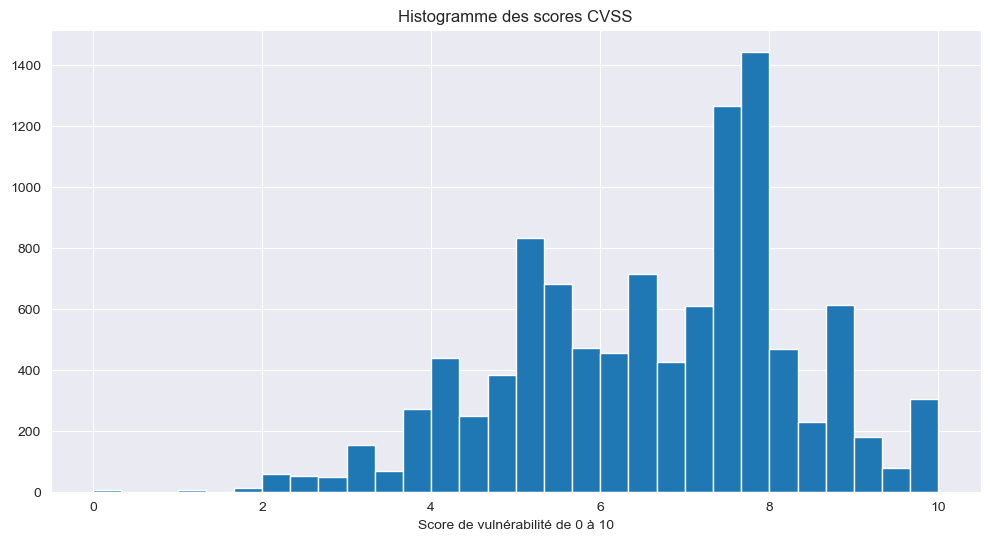

In [21]:
df_clean = df.dropna(subset=['cvss'])
df_with_epss = df.dropna(subset=['epss'])

print(f"Total des vulnérabilités {len(df)}")
print(f"Nombre de vulnérabilités avec score CVSS {len(df_clean)}")
print(f"NOmbre de vulnérabilités avec score EPSS {len(df_with_epss)}")


plt.figure(figsize=(12,6))
plt.hist(df_clean['cvss'], bins=30)
plt.title("Histogramme des scores CVSS")
plt.xlabel("Score de vulnérabilité de 0 à 10")
